# US Flood Claims (2015–2025)

This exploratory data analysis (EDA) focuses on a cleaned version of the FEMA Redacted Flood Claims located [here](https://www.fema.gov/openfema-data-page/fima-nfip-redacted-claims-v2). The goal is to uncover meaningful patterns in flood-related damages, frequencies, and risk categories from 2015 to June 16, 2025. These insights can help support risk modeling, insurance planning, and disaster response strategies.

**Dataset Overview**  
Rows: 594563  
Columns: 48    
Null values: None (post-cleaning)  
Time span: 2015 - June 16th, 2025  

The data has been preprocessed and cleaned to ensure consistency and accuracy. The cleaning scripts and methodology are documented in the `flood_data` notebook within this project. To better understand the dataset structure, the schema file is available at `data/recent_flood_claims_schema.csv`, detailing each variable’s description and data type. 

## Setup
This section loads required libraries and the cleaned dataset.

### Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from IPython.display import FileLink # exporting dataset

import matplotlib.pyplot as plt # plots
import matplotlib.ticker as ticker
import seaborn as sns # plots

### Load Data

In [2]:
# read data
flood_claims = pd.read_csv('/kaggle/input/recent-flood-claims/recent_flood_claims.csv', index_col = 0, low_memory = False)

# print head()
flood_claims.head()

,num_policy,loss_date,elevated,rated_zone,num_floors,occupancy,built,paid_build_claim,paid_contents_claim,paid_icc_add,...,flood_zone,build_type,rental,state,zipcode,census_tract,census_block,latitude,longitude,id
0,1,2017-08-26,0,AE,1.0,11.0,2017-08-26,50292.22,11607.90,0.0,...,AE,1.0,0,TX,77039.0,4.820122e+10,4.820122e+11,29.9,-95.3,5fa56e50-7923-44f3-832b-e527f639f28f
1,1,2017-08-26,1,X,1.0,1.0,2017-08-26,27213.28,8526.54,0.0,...,X,1.0,0,TX,77060.0,4.820122e+10,4.820122e+11,29.9,-95.4,2d96f6b6-d33b-4eda-8988-6ecbf481c5db
2,1,2022-09-28,0,AE,1.0,11.0,2022-09-28,250000.00,27000.00,0.0,...,AE,1.0,0,FL,33931.0,1.207106e+10,1.207106e+11,26.4,-81.9,37577287-ba9f-4cea-a1ed-ddc88be18348
3,1,2024-09-26,0,AE,1.0,11.0,2024-09-26,15570.67,0.00,0.0,...,X,1.0,0,FL,33924.0,1.207108e+10,1.207108e+11,26.5,-82.2,7413d61e-fb43-430e-99a3-0b8712c1944f
4,1,2017-08-26,1,AE,3.0,11.0,2017-08-26,5324.94,0.00,0.0,...,AE,1.0,0,TX,77025.0,4.820141e+10,4.820141e+11,29.7,-95.4,20a4bebf-8c90-464e-9173-78fcd1c168b8


In [3]:
# csv removed datetime type, put it back
flood_claims['loss_date'] = pd.to_datetime(flood_claims['loss_date'])

## Data Cleaning Summary
The raw FEMA Redacted Flood Claims dataset required extensive cleaning to ensure consistency, completeness, and usability for analysis. Below is a summary of the key data cleaning steps performed:

#### Filtering & Date Conversion:
- Extracted flood claims from 2015 to 2025.
- Converted loss_date to datetime format and extracted loss_year.

#### Column Management:
- Renamed columns for clarity.
- Dropped irrelevant or redundant columns.

#### Missing Value Imputation:
- Filled cover_required with 5 (Other) when missing.
- Filled rate_method, rated_zone, rcb, contents_deduct, build_type, build_deduct, and flood_zone with 'U' (Unknown).
- Filled damage_cause, nfip_name, and flood_name with 'unknown'.
- Filled occupancy and num_floors with '0' when missing.
- Filled icc, paid_icc_add, and paid_build_claim with 0.
- Filled census_block and census_tract with -1 to indicate missing geographic identifiers.
- Filled num_units with 1 assuming single-unit occupancy when missing.
- Reconstructed missing nfip_rated_num and nfip_num using corresponding state codes.
- If contents_cover was 0, then filled contents_replace_cost, contents_damage, contents_value, and paid_contents_claim with 0. Filled
      paid_contents_claim with net_contents_paid.  
      contents_replace_cost with contents_damage.
      contents_value using a cascade: contents_cover → paid_contents_claim.  
      contents_cover with contents_value if still missing.  

#### Flood Characteristics:
- Estimated missing flood_duration and flood_depth using the median of claims with the same state and loss_date.
- Remaining missing values were filled using state-level medians.

#### Geolocation:
- Estimated missing latitude and longitude using the zipcode via geocoding.
- Remaining gaps were filled using median coordinates for the same state.
- Performed reverse geocoding on latitude/longitude to fill missing zipcodes. Any remaining null values were filled using a valid zipcode from the same state.

## Data Overview

The cleaned FEMA Redacted Flood Claims dataset contains approximately 594,000 records and 48 features, each representing an individual insurance claim related to flooding in the United States between 2015 and 2025. These features span a wide range of data types, including numeric variables such as estimated damages and costs, categorical fields like flood zone or occupancy type, and geographic coordinates for spatial analysis.

- Initial inspection shows that the most claims cited September 26th, 2024 as the date of loss. This is likely in relation to Hurricane Helene which lasted from September 26-27th, 2024. 
- The dataset is free of null values following preprocessing. 
- The most common states in terms of flood claim volume include Florida, Texas, and Lousiana. 
- On average, each policyholder has 1.6 active insured units, indicating that most claims are for single-unit properties, but some involve multi-unit dwellings.
- The maximum payout for a single building claim is approximately $9,000,000, while the maximum total insurance coverage recorded across all claims reaches $272,500,000.
- The highest estimated building replacement cost recorded in the dataset is over $1.67 billion, highlighting the presence of highly valuable or large-scale properties.

This overview provides a solid foundation for further analysis. The following sections will explore key variables in more detail, identify trends over time, and investigate relationships between factors like claim size, property characteristics, and geographic location.

In [4]:
# print the shape of the data
print(f"Rows: {flood_claims.shape[0]}, Columns: {flood_claims.shape[1]}")

Rows: 594563, Columns: 48


In [5]:
# print the info 
flood_claims.info()

<class 'pandas.core.frame.DataFrame'>
Index: 594563 entries, 0 to 594562
Data columns (total 48 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   num_policy             594563 non-null  int64         
 1   loss_date              594563 non-null  datetime64[ns]
 2   elevated               594563 non-null  int64         
 3   rated_zone             594563 non-null  object        
 4   num_floors             594563 non-null  float64       
 5   occupancy              594563 non-null  float64       
 6   built                  594563 non-null  object        
 7   paid_build_claim       594563 non-null  float64       
 8   paid_contents_claim    594563 non-null  float64       
 9   paid_icc_add           594563 non-null  float64       
 10  post_firm              594563 non-null  int64         
 11  rate_method            594563 non-null  object        
 12  build_cover            594563 non-null  float64  

In [6]:
# print out the descriptive statistics
flood_claims.describe()

,num_policy,loss_date,elevated,num_floors,occupancy,paid_build_claim,paid_contents_claim,paid_icc_add,post_firm,build_cover,...,num_units,build_replace_cost,contents_replace_cost,flood_depth,rental,zipcode,census_tract,census_block,latitude,longitude
count,594563.000000,594563,594563.000000,594563.000000,594563.000000,5.945630e+05,594563.000000,594563.000000,594563.000000,5.945630e+05,...,594563.000000,5.945630e+05,5.945630e+05,594563.000000,594563.000000,594563.000000,5.945630e+05,5.945630e+05,594563.000000,594563.000000
mean,1.624265,2019-12-10 08:31:15.507221248,0.234397,1.557662,8.060281,4.903144e+04,9185.397634,146.544242,0.397584,3.346191e+05,...,2.098408,5.201257e+05,5.377897e+03,4.581721,0.052237,49317.964594,2.816422e+10,2.816422e+11,31.384445,-87.071975
min,1.000000,2015-01-01 00:00:00,0.000000,0.000000,0.000000,-2.016675e+05,-80000.000000,-6450.000000,0.000000,0.000000e+00,...,0.000000,-3.836593e+04,-8.000000e+04,-156.000000,0.000000,601.000000,-1.000000e+00,-1.000000e+00,-36.000000,-170.700000
25%,1.000000,2017-08-26 00:00:00,0.000000,1.000000,1.000000,1.009525e+03,0.000000,0.000000,0.000000,1.464000e+05,...,1.000000,1.013635e+05,0.000000e+00,0.000000,0.000000,32738.000000,1.209102e+10,1.209102e+11,28.000000,-94.400000
50%,1.000000,2018-10-11 00:00:00,0.000000,1.000000,11.000000,1.714711e+04,0.000000,0.000000,0.000000,2.500000e+05,...,1.000000,2.014110e+05,0.000000e+00,1.000000,0.000000,34607.000000,2.209507e+10,2.209507e+11,30.000000,-82.800000
75%,1.000000,2022-09-28 00:00:00,0.000000,2.000000,11.000000,6.994242e+04,6239.865000,0.000000,1.000000,2.500000e+05,...,1.000000,3.243295e+05,0.000000e+00,2.000000,0.000000,77025.000000,4.806101e+10,4.806101e+11,33.800000,-81.400000
max,1090.000000,2025-05-08 00:00:00,1.000000,6.000000,19.000000,9.000000e+06,757048.950000,60000.000000,1.000000,2.725000e+08,...,34970.000000,1.673931e+09,1.750000e+07,990.000000,1.000000,99999.000000,7.803096e+10,7.803096e+11,66.900000,174.000000
std,9.758112,NaN,0.423622,0.843621,5.271794,9.417262e+04,24163.249273,1994.521185,0.489399,2.160039e+06,...,47.412746,6.543804e+06,5.306548e+04,16.942728,0.222504,23721.364800,1.605165e+10,1.605165e+11,4.836584,9.371048


The number of policies

In [7]:
# get the summary stats of the categorical columns
flood_claims.select_dtypes(include='object').describe().T

,count,unique,top,freq
rated_zone,594563,63,AE,352435
built,594563,3768,2024-09-26,43160
rate_method,594563,20,RatingEngine,379291
build_deduct,594563,15,F,233713
damage_cause,594563,13,4,243013
contents_deduct,594563,15,1,189151
flood_name,594563,88,unknown,130304
nfip_num,594563,10283,120000,38594
nfip_name,594563,8769,"HOUSTON, CITY OF",36518
rcb,594563,3,A,349318


In [8]:
# get the unique values for top columns
cols_to_check = ['state', 'occupancy', 'flood_zone', 'damage_cause', 'nfip_name']
flood_claims[cols_to_check].nunique()

state             55
occupancy         15
flood_zone        59
damage_cause      13
nfip_name       8769
dtype: int64

## Exploratory Data Analysis

### Top 10 States by Claim Count

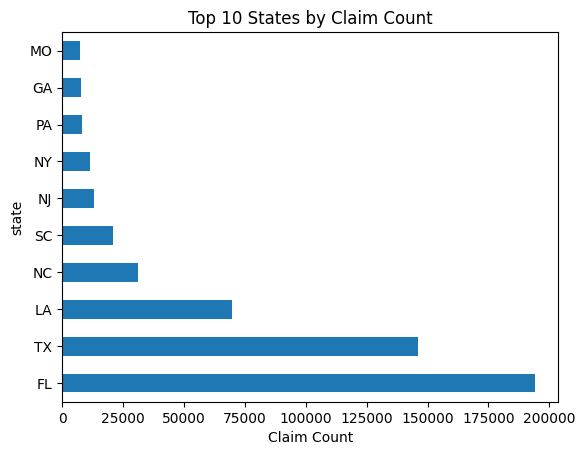

In [9]:
# get the state value counts based on the claim count
flood_claims['state'].value_counts().head(10).plot(kind='barh', title='Top 10 States by Claim Count')
plt.xlabel("Claim Count")
plt.show()

Florida and Texas have the most claims filed in the last 15 years. 

### Number of claims throughout the year over the years

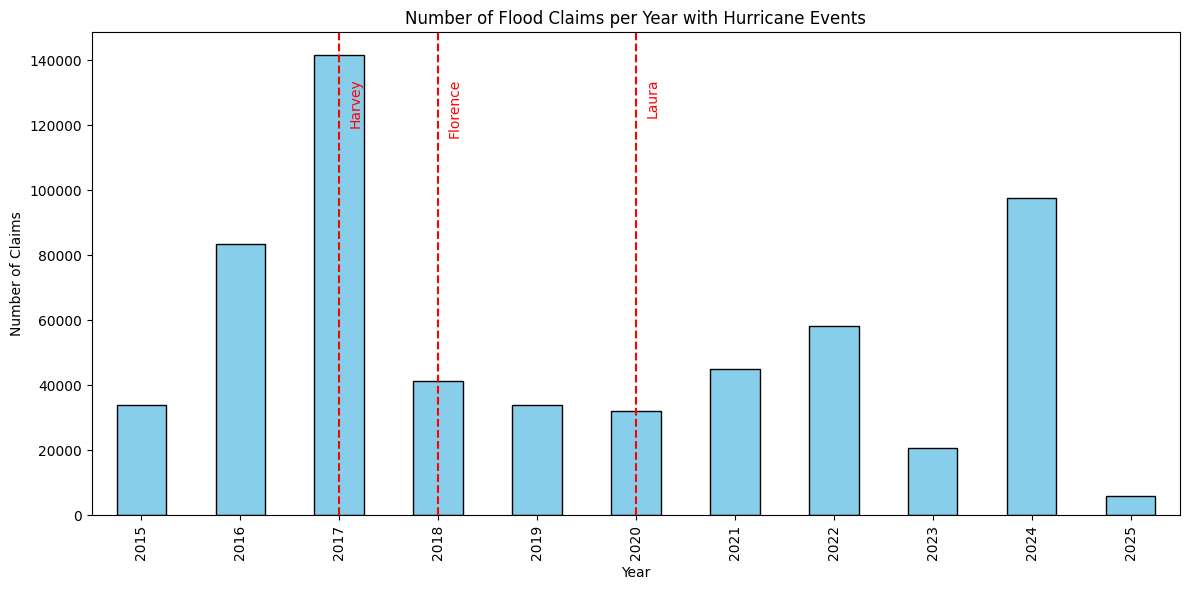

In [10]:
# get year from loss_date
flood_claims['loss_year'] = flood_claims.loss_date.dt.year

# count the number of claims per year
claim_count = flood_claims.groupby('loss_year')['id'].count()

# bar chart
plt.figure(figsize=(12,6))
claim_count.plot(kind='bar', color='skyblue', edgecolor='black')

# add hurricanes 
hurricane_events = {
    2005: 'Katrina',
    2012: 'Sandy',
    2017: 'Harvey',
    2018: 'Florence',
    2020: 'Laura'
}

# add vertical lines for events
for year, name in hurricane_events.items():
    if year in claim_count.index:
        plt.axvline(x=claim_count.index.get_loc(year), color='red', linestyle='--', linewidth=1.5)
        plt.text(claim_count.index.get_loc(year)+0.1, max(claim_count)*0.95, name, rotation=90, color='red', verticalalignment='top')

# add titles
plt.title('Number of Flood Claims per Year with Hurricane Events')
plt.xlabel('Year')
plt.ylabel('Number of Claims')
plt.tight_layout()
plt.show()

There is a high spike in 2017, with several claims indicating Hurrican Harvey as the flood cause. We also see a spike in 2024 which I will explore in later analysis. 

### Flood depth and duration throughout the years

In this section, I plot the most notable floods from 2017 along with the number of claims in Florida and Texas.  

/tmp/ipykernel_103/2379453046.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flood_2017['loss_month'] = flood_2017['loss_date'].dt.to_period('M').dt.to_timestamp()


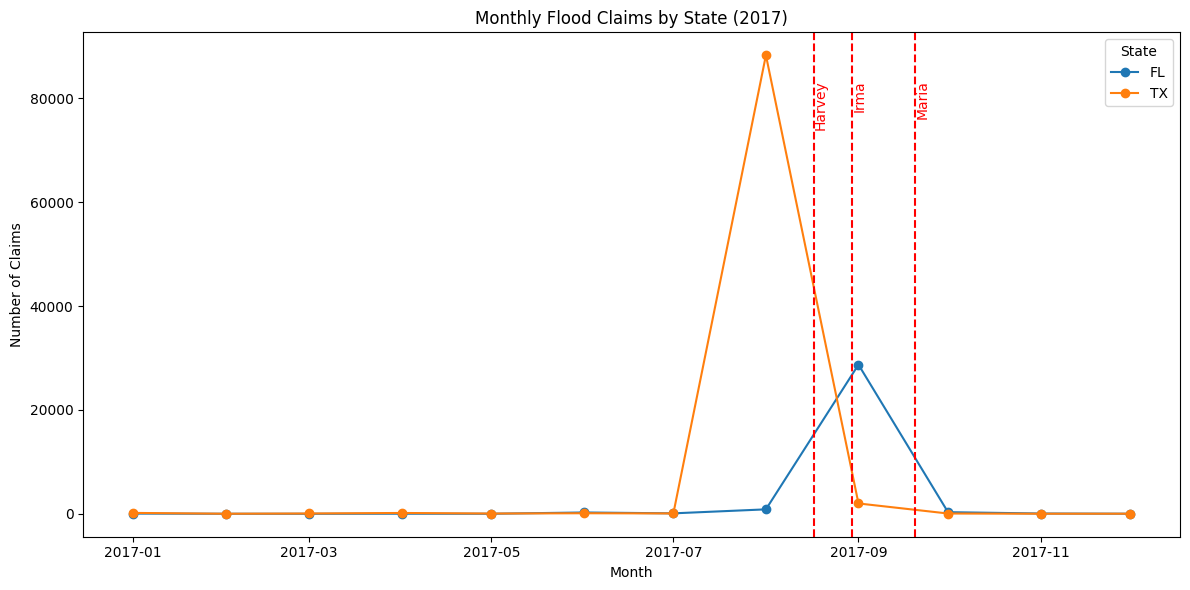

In [11]:
# get the count of claims in Florida and Texas
target_states = ['FL','TX']
flood_2017 = flood_claims[(flood_claims['loss_year'] == 2017) & 
                          (flood_claims['state'].isin(target_states))]

# create loss month
flood_2017['loss_month'] = flood_2017['loss_date'].dt.to_period('M').dt.to_timestamp()

# determine monthly claims count
monthly_counts = (
    flood_2017.groupby(['loss_month', 'state'])['id']
    .count()
    .reset_index()
)

# change orientation of columns
monthly_pivot = monthly_counts.pivot(index='loss_month', columns='state', values='id').fillna(0)

# line plot
plt.figure(figsize=(12,6))
for state in monthly_pivot.columns:
    plt.plot(monthly_pivot.index, monthly_pivot[state], marker='o', label=state)

# add event markers
event_dates = {
    'Harvey': '2017-08-17',
    'Irma': '2017-08-30',
    'Maria': '2017-09-20',  # Maria affected PR, but included here if useful
}

for event, date_str in event_dates.items():
    date = pd.to_datetime(date_str)
    plt.axvline(x=date, color='red', linestyle='--', linewidth=1.5)
    plt.text(date, plt.ylim()[1]*0.9, event, color='red', rotation=90, verticalalignment='top')

# Final touches
plt.title('Monthly Flood Claims by State (2017)')
plt.xlabel('Month')
plt.ylabel('Number of Claims')
plt.legend(title='State')
plt.tight_layout()
plt.show()

### Floods that hit hardest

There have been 88 different floods named for claims in the past 10 years. The most notabl are shown below:

|Flood|Claim Count|Year|Month|Locations|Building Claims Paid Amount|
|-----|-----|-----|-----|-----|-----|
|Hurricane Harvey|90019|2017|August|LA,TX|6731800920|
|Hurricane Helene|55811|2024|September|AL,FL,GA,KY,NC,SC,TN,VA,WV|5040444930|
|Hurricane Ian|47425|2022|September-October|FL,GA,NC,SC,VA|4145260246|
|Hurricane Irma |32454|2017|September|AL,FL,GA,PR,SC,VI|908361404|
|Mid-summer Severe Storm|29443|2016|August|LA|2120434000|
|Hurricane Ida |27388|2021|September|AL,CT,DC,DE,KY,LA,MA,MD,MS,NJ,NY,OH,PA,RI,TN,VA,WV|1054431654|
|Hurricane Matthew |21333|2016|October|FL,GA,NC,SC,VA|536875850|
|Hurricane Milton  |20664|2024|October|FL,GA,SC|891010726.30|
|Hurricane Florence|16405|2018|September|NC,SC,VA|604168730|

In [12]:
# get number of flood names from claims
flood_claims.flood_name.nunique()

88

In [13]:
# get value counts
flood_claims.flood_name.value_counts()[:10]

flood_name
unknown                     130304
Hurricane Harvey             90019
Hurricane Helene             55811
Hurricane Ian                47425
Hurricane Irma               32454
Mid-summer severe storms     29443
Hurricane Ida                27388
Hurricane Matthew            21333
Hurricane Milton             20664
Hurricane Florence           16405
Name: count, dtype: int64

In [14]:
# get a list of affected areas
# create a new month column
flood_claims['loss_month'] = flood_claims.loss_date.dt.month

# define flood names to filter
floods = ['Hurricane Harvey','Hurricane Helene', 'Hurricane Ian','Hurricane Irma','Mid-summer severe storms', 'Hurricane Ida', 'Hurricane Matthew', 'Hurricane Milton', 'Hurricane Florence']

# select all claims where the flood name matches one defined
top_floods = flood_claims[flood_claims.flood_name.isin(floods)].loc[:,['flood_name','loss_month', 'loss_year','paid_build_claim','net_build_paid','flood_depth', 'flood_duration','state']]

# print first few
top_floods.head(3)

,flood_name,loss_month,loss_year,paid_build_claim,net_build_paid,flood_depth,flood_duration,state
0,Hurricane Harvey,8,2017,50292.22,50292.22,1.0,0.0,TX
1,Hurricane Harvey,8,2017,27213.28,27213.28,1.0,0.0,TX
2,Hurricane Ian,9,2022,250000.00,250000.00,8.0,1.0,FL


In [15]:
# top floods summary 
flood_summary = (
    top_floods
    .groupby(['flood_name', 'state'])
    .agg(
        median_loss_month=('loss_month', 'median'),
        median_loss_year=('loss_year', 'median'),
        total_paid_build_claim=('paid_build_claim', 'sum'),
        total_net_build_paid=('net_build_paid', 'sum'),
        avg_flood_depth=('flood_depth', 'mean'),
        avg_flood_duration=('flood_duration', 'mean')
    )
    .reset_index()
)

# print summary sorted by flood name then state
flood_summary.sort_values(['flood_name','state'])

,flood_name,state,median_loss_month,median_loss_year,total_paid_build_claim,total_net_build_paid,avg_flood_depth,avg_flood_duration
0,Hurricane Florence,NC,9.0,2018.0,5.167977e+08,5.161562e+08,1.230003,0.000000
1,Hurricane Florence,SC,9.0,2018.0,8.677182e+07,8.676191e+07,1.907837,0.000000
2,Hurricane Florence,VA,9.0,2018.0,5.992100e+05,5.992100e+05,0.693548,0.000000
3,Hurricane Harvey,LA,8.0,2017.0,1.242892e+07,1.236040e+07,1.036204,0.000000
4,Hurricane Harvey,TX,8.0,2017.0,6.719372e+09,6.713742e+09,2.284422,0.000000
5,Hurricane Helene,AL,9.0,2024.0,1.095857e+04,1.095857e+04,-32.750000,13.500000
6,Hurricane Helene,FL,9.0,2024.0,4.857238e+09,4.856390e+09,4.570097,0.002259
7,Hurricane Helene,GA,9.0,2024.0,2.349517e+07,2.340643e+07,11.201674,0.009132
8,Hurricane Helene,KY,9.0,2024.0,1.272811e+04,1.272811e+04,21.000000,0.000000
9,Hurricane Helene,NC,9.0,2024.0,1.348143e+08,1.348143e+08,8.910864,0.005014


### Correlation Heatmap

In this section, I create a heatmap of the column correlations to determine the linear relationship. Here are the most notable positive and negative correlations.

**Positive**
- (paid_build_claim, net_build_paid) at 0.95
- (build_cover, paid_build_claim) at ~0.67
- (contents_damage, contents_value) at ~0.57
- (latitude, loss_month) at 0.25 which could suggest seasonal geographic flooding patterns

**Negative**
- flood_depth has very weak correlation with most variables
- zip_code, census_tract, and census_block show low correlations with numerical variables

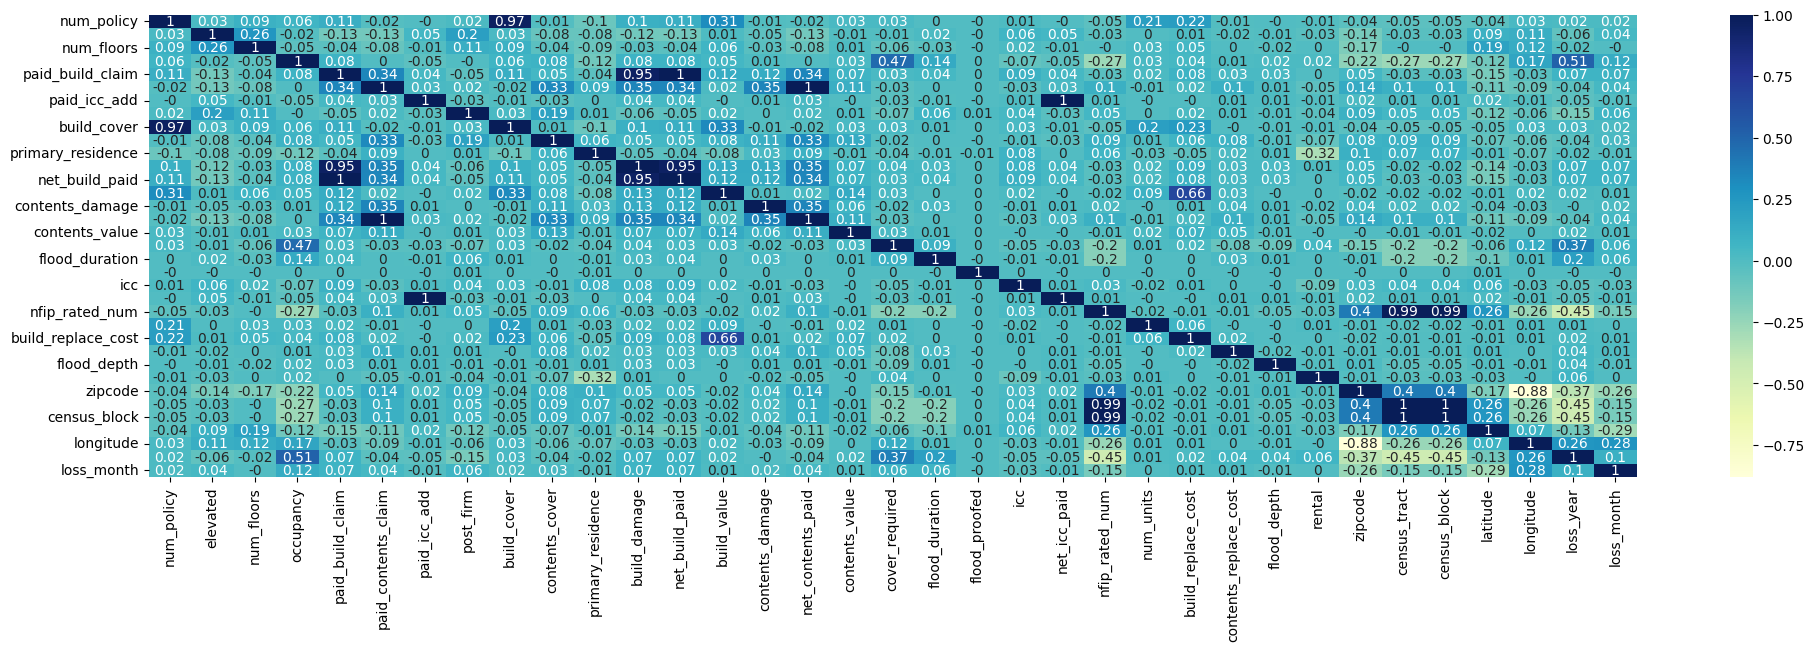

In [16]:
# select numeric columns
flood_claims_num = flood_claims.select_dtypes(include=np.number)

# calculate correlation matrix
corr_matrix = round(flood_claims_num.corr(),2)

# generate heatmap of matrix
plt.figure(figsize=(24,6))
sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True)

# display
plt.show()

Based on the heatmap, a lot of variables have a small to no linear relationship. 


### How many claims fall within flood zones? Has this changed over the years?

From my analysis, I have determined that the number of claims from High and Moderate Risk flood zones has gone down over time, but the number of Uncertain Flood Risk claims has gone up. 

The number of Uncertain and High Risk Claims both spiked in 2024. This makes sense as the total number of flood claims in 2024 was 97,598 versus the 20,779 made in 2023. I can see from the flood names listed in 2024 claims that there were at least 5 hurricanes, a tropical cylone, and explicit state flooding. 

In [17]:
# high risk flood zones
high_risk = ['A', 'AE', 'A1', 'A2', 'A30', 'A99', 'AH', 'AHB', 'AO', 'AOB', 
             'AR', 'AR/AE', 'AR/A1', 'AR/A30', 'AR/AH', 'AR/AO', 'AR/A',
             'V', 'VE', 'V1', 'V30']

# moderate risk flood zones
moderate_risk = moderate_risk = ['X', 'B']

# minimal risk flood zones
minimal_risk = ['C']

# uncertain risk
uncertain_risk = ['D', 'u']

# other
other_zones = ['ARE', 'ARH', 'ARO', 'ARA']  # or anything that doesn’t fit above

# create a new column that has the flood zone risk grouping
def classify_zone(zone):
    if pd.isna(zone):
        return 'Unknown'
    elif zone in high_risk:
        return 'High Risk'
    elif zone in moderate_risk:
        return 'Moderate Risk'
    elif zone in minimal_risk:
        return 'Minimal Risk'
    elif zone in uncertain_risk:
        return 'Uncertain Risk'
    else:
        return 'Other'

flood_claims['flood_zone_group'] = flood_claims['flood_zone'].apply(classify_zone)

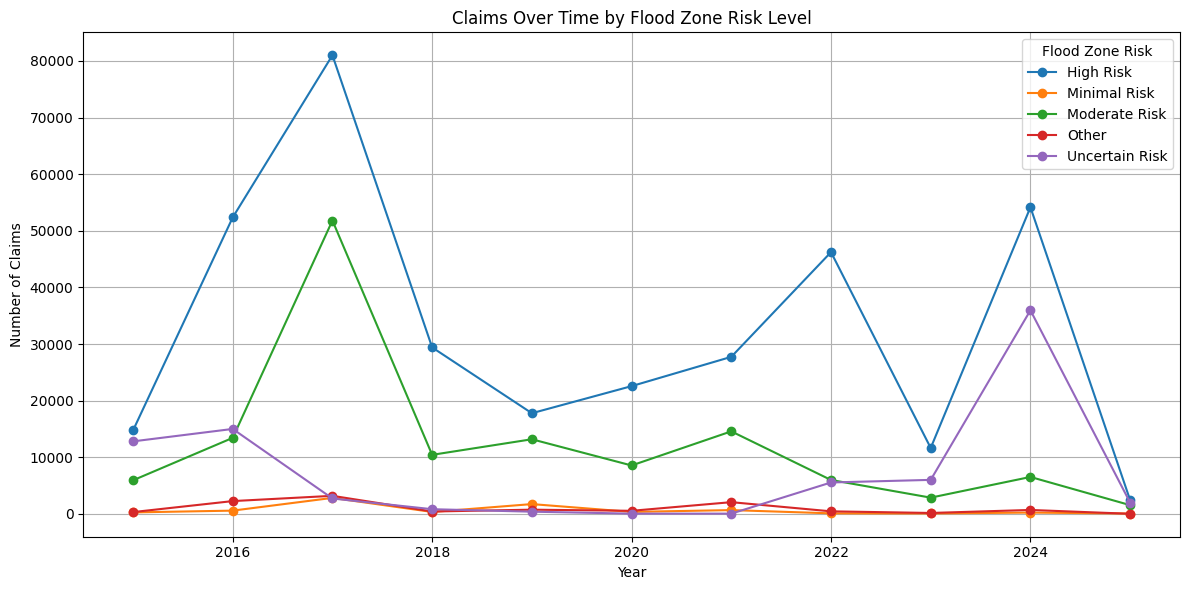

In [18]:
# plot the zones
zone_trends = (
    flood_claims
    .groupby(['loss_year', 'flood_zone_group'])
    .size()
    .reset_index(name='claim_count')
)

zone_trends_pivot = zone_trends.pivot(index='loss_year', columns='flood_zone_group', values='claim_count').fillna(0)

# plot
zone_trends_pivot.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Claims Over Time by Flood Zone Risk Level')
plt.xlabel('Year')
plt.ylabel('Number of Claims')
plt.grid(True)
plt.legend(title='Flood Zone Risk')
plt.tight_layout()
plt.show()

In [19]:
# get the number of claims per year
flood_claims.groupby('loss_year').size().reset_index(name='num_claims')

,loss_year,num_claims
0,2015,34069
1,2016,83656
2,2017,141583
3,2018,41441
4,2019,33850
5,2020,32078
6,2021,45123
7,2022,58337
8,2023,20779
9,2024,97598


In [20]:
# most notable flood names in 2024
flood_claims[flood_claims.loss_year == 2024].flood_name.value_counts()

flood_name
Hurricane Helene                         55811
Hurricane Milton                         20664
unknown                                  10403
Hurricane Beryl                           2396
Hurricane Debby                           2348
Hurricane Francine                        2041
June South Florida Flooding               1382
Texas Spring Flooding                     1014
Tropical Cyclone Eight                     715
June Midwest Flooding                      312
San Diego Flooding                         194
February California Atmospheric River      177
June TS Alberto                            123
Iowa Flooding                               18
Name: count, dtype: int64

### Are claim amounts higher for particular building types or occupancies?

**Building Type**  
Condos have the highest average paid claim amount on the building, followed closely by Apartments and Commercial Buildings.

**Occupancy Type**  
5+ Insured Units have the highest average, followed by 2-4 Insured Units and Condo Associations. 

#### Building Type

In [21]:
# create a summary of building types then sort by average paid building claim amount
building_type_summary = (
    flood_claims.groupby('build_type').agg(
        claim_count=('paid_build_claim', 'count'),
        avg_claim=('paid_build_claim', 'mean'),
        median_claim=('paid_build_claim', 'median'),
        total_claim=('paid_build_claim', 'sum')
    )
    .sort_values(by='avg_claim', ascending=False)
)

# create legend for building types
build_type_map = {
    '1.0': 'Main',
    '2.0': 'Guest',
    '3.0': 'Garage',
    '4.0': 'Ag',
    '5.0': 'Warehouse',
    '6.0': 'Rec/Pool',
    '7.0': 'Tools',
    '8.0': 'Other',
    '9.0': 'Barn',
    '10.0': 'Apt',
    '11.0': 'Apt Unit',
    '12.0': 'Co-op',
    '13.0': 'Co-op Unit',
    '14.0': 'Commercial',
    '15.0': 'Condo',
    '16.0': 'Condo Unit',
    '17.0': 'Religious',
    '18.0': 'Mobile',
    '19.0': 'Trailer',
    '20.0': 'Townhouse',
    'u': 'unknown'
}

# apply to new columns
flood_claims['build_type_label'] = flood_claims['build_type'].map(build_type_map)

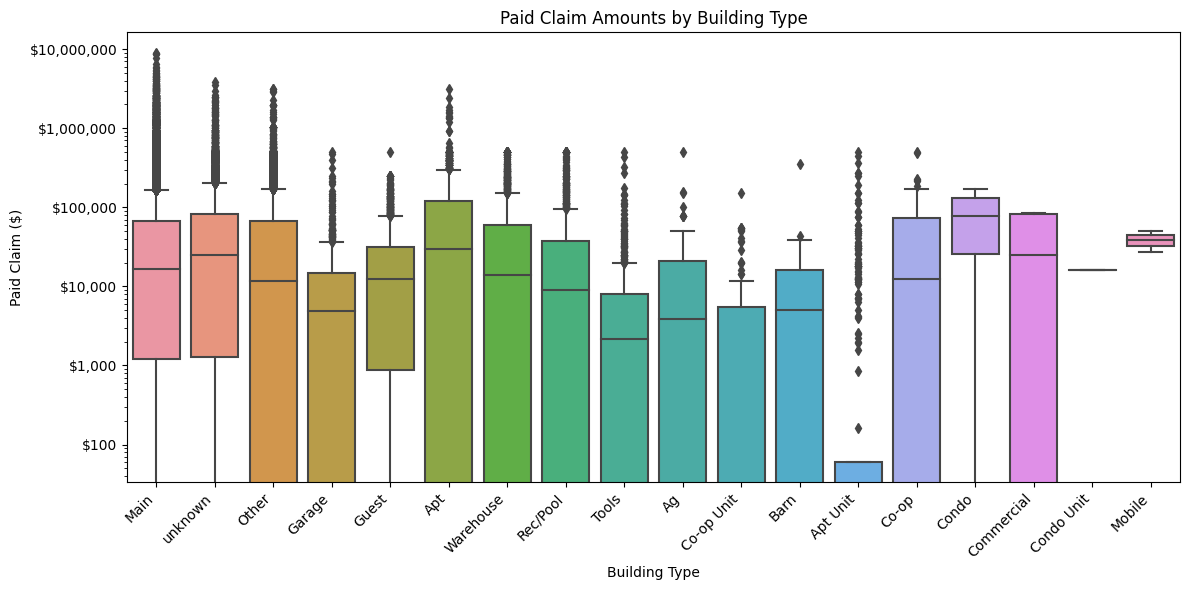

In [22]:
# plot boxplot of paid building claims for each building type
plt.figure(figsize=(12, 6))
sns.boxplot(x='build_type_label', y='paid_build_claim', data=flood_claims)
plt.yscale('log') 

# format y-axis with dollar values
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}')) # use ticket

plt.title('Paid Claim Amounts by Building Type')
plt.xlabel('Building Type')
plt.ylabel('Paid Claim ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Occupancy Type


In [23]:
# create a summary of occupancy type then sort by average building paid claim amount
occupancy_type_summary = (
    flood_claims.groupby('occupancy').agg(
        claim_count=('paid_build_claim', 'count'),
        avg_claim=('paid_build_claim', 'mean'),
        median_claim=('paid_build_claim', 'median'),
        total_claim=('paid_build_claim', 'sum')
    )
    .sort_values(by='avg_claim', ascending=False)
)

# create legend for occupancy types
occupy_type_map = {
    0: 'Unknown',
    1: 'Single-Family',
    2: '2–4 Units',
    3: '5+ Units',
    4: 'Non-Res Building',
    6: 'Non-Res Business',
    11: 'Single-Family (not condo/mobile)',
    12: '2–4 Units (Insured)',
    13: '5+ Units (Insured)',
    14: 'Mobile Home (Res)',
    15: 'Condo Assoc',
    16: 'Single Unit in Multi',
    17: 'Mobile Home (Non-Res)',
    18: 'Non-Res Building',
    19: 'Non-Res Unit'
}

# apply to new columns
flood_claims['occupy_type_label'] = flood_claims['occupancy'].map(occupy_type_map)

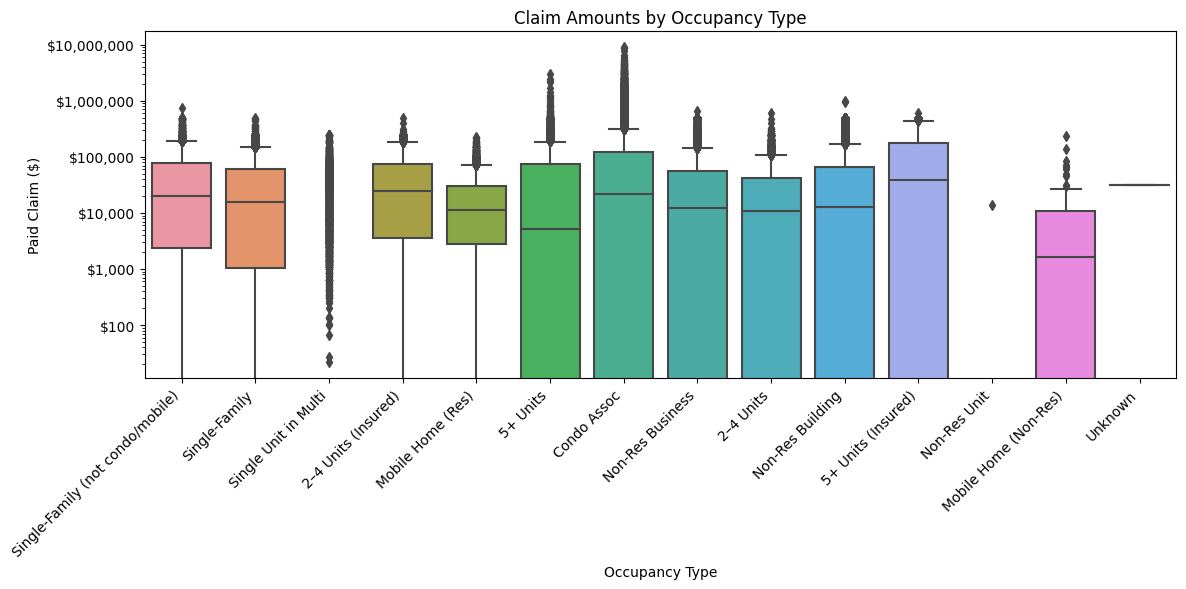

In [24]:
# plot boxplot of paid building claims for each building type
plt.figure(figsize=(12, 6))
sns.boxplot(x='occupy_type_label', y='paid_build_claim', data=flood_claims)
plt.yscale('log') 

# format y-axis with dollar values
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}')) # use ticket

plt.title('Claim Amounts by Occupancy Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.xlabel('Occupancy Type')
plt.ylabel('Paid Claim ($)')
plt.show()

### Do longer floods cause more damage?

In [26]:
# calculate the correlation
corr = flood_claims['flood_duration'].corr(flood_claims['build_damage'])
print(f"Correlation between flood duration and building damage amount: {corr:.3f}")

# calculate the correlation
corr = flood_claims['flood_depth'].corr(flood_claims['build_damage'])
print(f"Correlation between flood depth and building damage amount: {corr:.3f}")

Correlation between flood duration and building damage amount: 0.029
Correlation between flood depth and building damage amount: 0.029


These weak correlations suggest other factors (property value, geography, building quality) are more predictive of damage.

### Are there trends or spikes linked to specific flood events or seasons?  

In [27]:
# Extract day (optional, if you want)
flood_claims['loss_day'] = flood_claims['loss_date'].dt.day

# group by year and month to get monthly claims count and total damage
monthly_claims = flood_claims.groupby(['loss_year', 'loss_month']).size().reset_index(name='claim_count')
monthly_damage = flood_claims.groupby(['loss_year', 'loss_month'])['build_damage'].sum().reset_index()

# create a full datetime column for the first day of each month (rename columns on the fly)
monthly_claims['loss_date'] = pd.to_datetime(
    monthly_claims.rename(columns={'loss_year': 'year', 'loss_month': 'month'})
                  .loc[:, ['year', 'month']]
                  .assign(day=1)
)

monthly_damage['loss_date'] = pd.to_datetime(
    monthly_damage.rename(columns={'loss_year': 'year', 'loss_month': 'month'})
                  .loc[:, ['year', 'month']]
                  .assign(day=1)
)

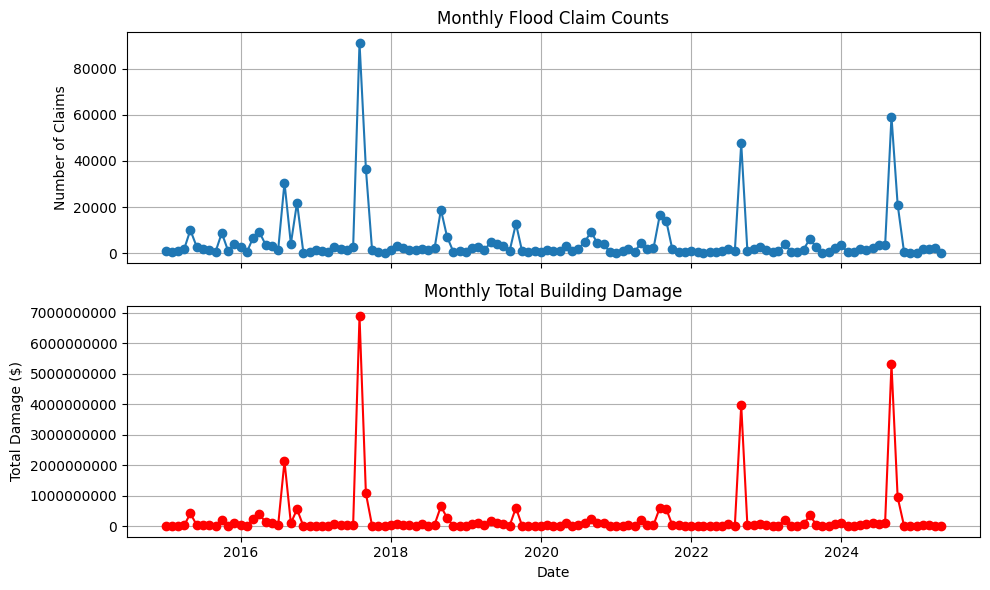

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True)

ax1.plot(monthly_claims['loss_date'], monthly_claims['claim_count'], marker='o')
ax1.set_title('Monthly Flood Claim Counts')
ax1.set_ylabel('Number of Claims')
ax1.grid(True)

ax2.plot(monthly_damage['loss_date'], monthly_damage['build_damage'], marker='o', color='red')
ax2.set_title('Monthly Total Building Damage')
ax2.set_ylabel('Total Damage ($)')
ax2.set_xlabel('Date')
ax2.grid(True)
ax2.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis

plt.tight_layout()
plt.show()

## Summary

This analysis reveals that:
- Claims are seasonal, peaking in late summer to fall.
- 2024 had historically high flood claim activity.
- Florida and Texas dominate in claim count and dollar value.
- Condo and multi-unit buildings see the highest average damages.
- Surprisingly, flood duration and depth have weak predictive value on damage amount.

## Visualizing
From here, I will export my data for visualization in Tableau.

In [29]:
flood_claims.to_csv('flood_claims.csv')
FileLink("flood_claims.csv")

/kaggle/working/flood_claims.csv